## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io
import itertools as it
import scipy.special as psi
plt.style.use('classic')
import seaborn as sns
import pandas as pd
import math as mt
import time
import sys

sys.path.insert(1, '/rds/general/user/lr4617/home/4th_Year_Project/Final_Year_Project/')

from scipy.io import loadmat
from scipy import stats
from numpy.random import seed
from numpy.random import rand
from scipy.integrate import quad
from scipy.io import savemat
from tempfile import TemporaryFile
from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.decomposition import KernelPCA
from mpl_toolkits import mplot3d
from mPE_fn import mPE_
from scipy.spatial import distance
from scipy.stats import entropy
from mPE_ultis import integrand, ubble, array_list, permutation
from util import rolling_mean, probability, probability_v2, get_mPE_matrix
from sklearn.cluster import KMeans

## Load Data - Create Dataset

In [2]:
###################################################################################################################################################
#################################################################### PARAMS #######################################################################
###################################################################################################################################################
use_all = True

###################################################################################################################################################
################################################################ LOAD TRAJECTORIES ################################################################
###################################################################################################################################################

print('########################## LOADING TRAJECTORIES ##########################')

modes = ['normal', 'caffeine', 'amphetamine']
names = []
root_dir = '/rds/general/user/lr4617/home/4th_Year_Project/CAPTURE_rat_multidimensional/raw_data/'
# load entire high-dimensional trajectories
cnt = 0
lengths = []
for mode in modes:
    trajs = os.listdir(root_dir + mode + '/' )
    trajs.sort()
    for traj_n in trajs:
        if traj_n != '.ipynb_checkpoints': 
            names.append(traj_n)
            print(traj_n)
            # loading entire high-dimensional trajectory
            path = root_dir + mode + '/' + traj_n + '/' + 'trajectories_na/'
            trajectories = os.listdir(path)
            # removing NaN columns
            nan_cols = []
            for i, time_bin in enumerate(trajectories):
                if time_bin != 'behavs' and time_bin != '.ipynb_checkpoints':
                    trajectory = loadmat(path + time_bin)
                    trajectory = trajectory['trajectory'] 
                    for i in range(trajectory.shape[1]):
                        if np.isnan(trajectory[:, i]).all():
                            nan_cols.append(i)
            
            # decide whether to use sub-sampling or not
            nan_cols = np.asarray(nan_cols)
            a = 0
            if use_all:
                sub_sampling = 1
                window = 1
            elif not use_all:
                sub_sampling = 10
                window = 150
            
            # create trajectory
            if nan_cols.size > 0:
                if len(np.where(nan_cols==nan_cols[0])[0])*3 == len(nan_cols):
                    sampled_trajectories = np.zeros( (int((trajectory.shape[0]*len(trajectories))/sub_sampling), trajectory.shape[1]-len(nan_cols)) )
            else:
                sampled_trajectories = np.zeros( (int((trajectory.shape[0]*len(trajectories))/sub_sampling), trajectory.shape[1]) )

            for i, time_bin in enumerate(trajectories):
                if time_bin != 'behavs':
                    trajectory = loadmat(path + time_bin)
                    trajectory = trajectory['trajectory'] 
                    if nan_cols.size > 0:
                        trajectory = np.delete(trajectory, nan_cols, 1)
                    
                    mov_av_traj = rolling_mean(trajectory, window, overlapping=True)
                    
                    idxs = np.arange(0, mov_av_traj.shape[0], sub_sampling)
                    mov_av_traj =  mov_av_traj[idxs, :]
                    idx_2 = i*mov_av_traj.shape[0]
                    
                    sampled_trajectories[idx_2:idx_2+mov_av_traj.shape[0], 0:sampled_trajectories.shape[1]] = mov_av_traj
                    
            # convert nan to number when not it is a sparse recurrence (not an entire column)
            sampled_trajectories = np.nan_to_num(sampled_trajectories)
            lengths.append(sampled_trajectories.shape[0])
            
            print(sampled_trajectories.shape)

            # append trajectory to all trajectories
            if cnt==0:
                rats = sampled_trajectories
            if cnt>0:
                rats = np.concatenate((rats, sampled_trajectories), axis=0)
                
            cnt += 1

lenghts = np.asarray(lengths)
path_out = '/rds/general/user/lr4617/home/4th_Year_Project/Final_Report/control_analysis/lengths.npy'
# np.save(path_out, lengths)

path_out = '/rds/general/user/lr4617/home/4th_Year_Project/Final_Report/control_analysis/rats_sampling_10_window_150_ordered.npy'
# np.save(path_out, rats)

########################## LOADING TRAJECTORIES ##########################
traj_1
(8208000, 60)
traj_2


KeyboardInterrupt: 

## Dimensionality Reduction - PCA

In [10]:
explained_var_normal = np.zeros((4,60))
explained_var_caffeine = np.zeros((4,60))
explained_var_amphetamine = np.zeros((4,60))

for i, length in enumerate(lengths):
    # inspecting inter-dimensional variance with PCA
    if i == 0:
        idx = 0
    else:
        idx += lengths[i-1]

    traj = rats[idx:idx+length, :]

    pca = PCA()
    pca.fit(traj)
    
    explained_var_plot = [np.sum(pca.explained_variance_ratio_[0:i+1]) for i in range(len(pca.explained_variance_ratio_))]
    print(explained_var_plot[0], explained_var_plot[1], explained_var_plot[2])
    if i <= 3:
        explained_var_normal[i, :] = explained_var_plot
        
    if i > 3 and i < 8:
        explained_var_caffeine[i-4, :] = explained_var_plot
    
    if i >= 8: 
        explained_var_amphetamine[i-8, :] = explained_var_plot
    
    # reduce data according to explained variance values using linear PCA
    pca = PCA(n_components=3)
    reduced_traj = pca.fit_transform(traj)

0.3736897803299907 0.703304785474048 0.906016829373617
0.5387965792995498 0.6716215655539349 0.7455050324329868
0.3346390483053206 0.6402882486617305 0.7486171526747691
0.326416777722376 0.614866030514934 0.8259347621622171
0.46286372488462835 0.736838950385478 0.8493039450589196
0.35565067025972874 0.6845859949865094 0.8276073075876835
0.3709222707250332 0.69576655299604 0.8775699950568064
0.41664573671417515 0.724515723008468 0.8810475399354538
0.4196026003201765 0.6894179033918314 0.8865646052886422
0.3675912167349405 0.6301050937148842 0.7648890171173716
0.4151148861022438 0.7278937796682441 0.8657198222722218
0.49167400228919117 0.809806272072062 0.9070414421975477


In [14]:
np.std(explained_var_normal, axis=0)

array([8.58316065e-02, 3.32091670e-02, 6.58637192e-02, 6.42783257e-02,
       5.72788431e-02, 5.26925147e-02, 4.80595087e-02, 4.34668365e-02,
       3.85322495e-02, 3.47580498e-02, 3.17077889e-02, 2.88031887e-02,
       2.62909770e-02, 2.39973899e-02, 2.18107179e-02, 1.99964180e-02,
       1.82718656e-02, 1.67446080e-02, 1.53771758e-02, 1.41124302e-02,
       1.29636210e-02, 1.19479877e-02, 1.09921978e-02, 1.00813063e-02,
       9.25941131e-03, 8.50199541e-03, 7.76586340e-03, 7.07850932e-03,
       6.46536632e-03, 5.87784563e-03, 5.34891443e-03, 4.86753048e-03,
       4.42959446e-03, 4.02841891e-03, 3.64840575e-03, 3.29560318e-03,
       2.99247025e-03, 2.70941304e-03, 2.44956504e-03, 2.20124790e-03,
       1.97641360e-03, 1.75806251e-03, 1.56060230e-03, 1.39323955e-03,
       1.23038132e-03, 1.08225004e-03, 9.46695225e-04, 8.23532227e-04,
       7.10919858e-04, 6.06012703e-04, 5.08440561e-04, 4.19092477e-04,
       3.36877099e-04, 2.67392651e-04, 2.05186916e-04, 1.43744644e-04,
      

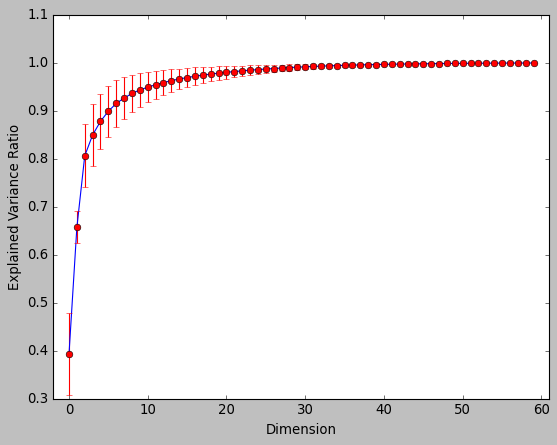

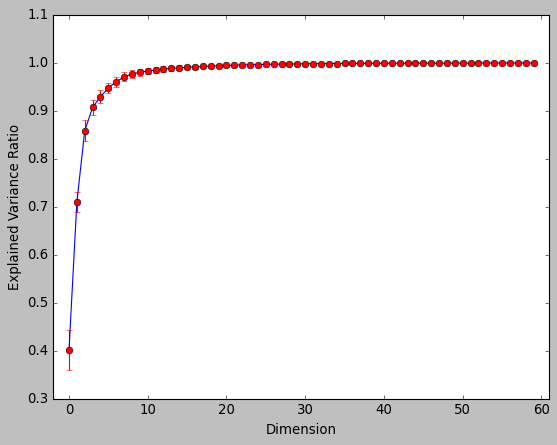

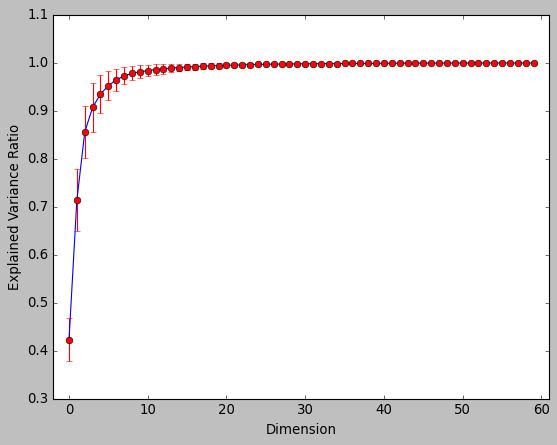

In [18]:

fig, axs = plt.subplots(1, 3, figsize=(20, 10))
labels = ['(A)', '(B)', '(C)', '(D)', '(E)', '(F)', '(G)', '(H)']

axs[0].plot(np.arange(explained_var_normal.shape[1]), np.mean(explained_var_normal,axis=0))
axs[0].errorbar(np.arange(explained_var_normal.shape[1]), np.mean(explained_var_normal, axis=0), yerr=np.std(explained_var_normal, axis=0), fmt="o", color="r")
axs[0].set_ylabel('Cumulative Explained Variance Ratio')
axs[0].set_xlabel('Dimension')
axs[0].set_ylim([0.3, 1.1])
axs[0].set_xlim([-2, 61])
axs[0].grid(True, which="major")
axs[0].text(-0.05, 1.13, labels[0], transform=axs[0].transAxes, fontsize=16, fontweight='bold', va='top', ha='right') 


axs[1].plot(np.arange(explained_var_caffeine.shape[1]), np.mean(explained_var_caffeine,axis=0))
axs[1].errorbar(np.arange(explained_var_caffeine.shape[1]), np.mean(explained_var_caffeine, axis=0), yerr=np.std(explained_var_caffeine, axis=0), fmt="o", color="r")
axs[1].set_ylabel('Cumulative Explained Variance Ratio')
axs[1].set_xlabel('Dimension')
axs[1].set_ylim([0.3, 1.1])
axs[1].set_xlim([-2, 61])
axs[1].grid(True, which="major")
axs[1].text(-0.05, 1.13, labels[1], transform=axs[1].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')


axs[2].plot(np.arange(explained_var_amphetamine.shape[1]), np.mean(explained_var_amphetamine,axis=0))
axs[2].errorbar(np.arange(explained_var_amphetamine.shape[1]), np.mean(explained_var_amphetamine, axis=0), yerr=np.std(explained_var_amphetamine, axis=0), fmt="o", color="r")
axs[2].set_ylabel('Cumulative Explained Variance Ratio')
axs[2].set_xlabel('Dimension')
axs[2].set_ylim([0.3, 1.1])
axs[2].set_xlim([-2, 61])
axs[2].grid(True, which="major")
axs[2].text(-0.05, 1.13, labels[2], transform=axs[2].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')



         


## Dimensionality Reduction - Drug

In [7]:
expm = 'drug'
path = '/rds/general/user/lr4617/home/4th_Year_Project/CAPTURE_rat_multidimensional/raw_data/' + expm + '/'
trajectories = os.listdir(path)
print(trajectories)

lengths = []
# nan_cols = [12,13,14]
sub_sampling = 60;
for n, traj_n in enumerate(trajectories):
    if traj_n != ".ipynb_checkpoints":
        path_n = path + traj_n + '/trajectories_na/'
        trajs = os.listdir(path_n)
        trajectory = loadmat(path_n + trajs[0])
        trajectory = trajectory['trajectory']
        # all_trajectories = np.zeros((int(trajectory.shape[0]/sub_sampling)*len(trajs), trajectory.shape[1]-len(nan_cols)))
        all_trajectories = np.zeros((int(trajectory.shape[0]/sub_sampling)*len(trajs), trajectory.shape[1]))
        for i, time_bin in enumerate(trajs):
            if time_bin != 'behavs':
                trajectory = loadmat(path_n + time_bin)
                trajectory = trajectory['trajectory'] 
                # trajectory = np.delete(trajectory, nan_cols, 1)
                idx = np.round(np.linspace(0, trajectory.shape[0] - 1, sub_sampling)).astype(int)
                trajectory = trajectory[idx]
                idx_2 = i*trajectory.shape[0]
                all_trajectories[idx_2:idx_2+trajectory.shape[0], 0:trajectory.shape[1]] = trajectory

        lengths.append(all_trajectories.shape[0])

        if n==0:
            rats = all_trajectories
        if n>0:
            rats = np.concatenate((rats, all_trajectories), axis=0)

print(rats.shape)

['traj_5', 'traj_8', 'traj_3', 'traj_4', 'traj_7', 'traj_2', 'traj_6', 'traj_1']
(423000, 60)


In [8]:
nan_cols = []
for i in range(rats.shape[1]):
    if np.isnan(rats[:, i]).any():
        rats = np.nan_to_num(rats)
        cnt = np.count_nonzero(np.isnan(rats[:, i]))
        nan_cols.append(cnt)

print(nan_cols)

[0]


Explained variance 3 PCs: 0.8650886239700754


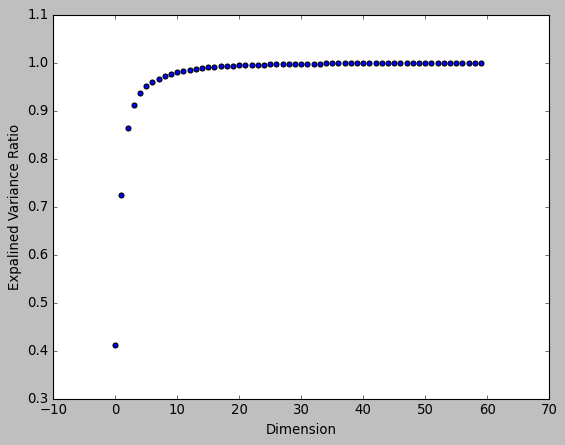

[[ 7.93502291e-01  2.59381459e-15  1.45264786e-14]
 [ 2.59381459e-15  6.01181911e-01 -1.13922961e-14]
 [ 1.45264786e-14 -1.13922961e-14  2.67846799e-01]]
Explained variance 3 PCs: 0.8844123528154164


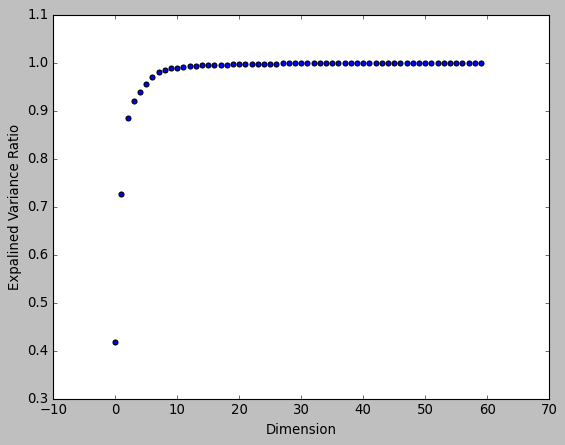

[[ 8.10649150e-01  3.95553767e-14 -7.25400025e-15]
 [ 3.95553767e-14  6.00192460e-01 -8.75201251e-15]
 [-7.25400025e-15 -8.75201251e-15  3.02848858e-01]]
Explained variance 3 PCs: 0.7703614776225719


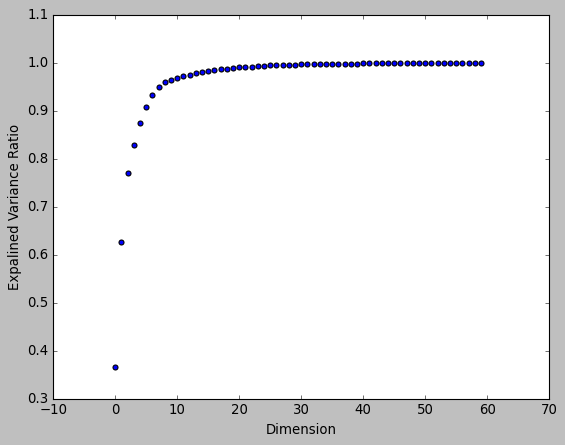

[[ 7.15522112e-01 -8.37401620e-15  3.36724423e-15]
 [-8.37401620e-15  5.05772156e-01 -1.24916735e-14]
 [ 3.36724423e-15 -1.24916735e-14  2.79023301e-01]]
Explained variance 3 PCs: 0.8295284904523152


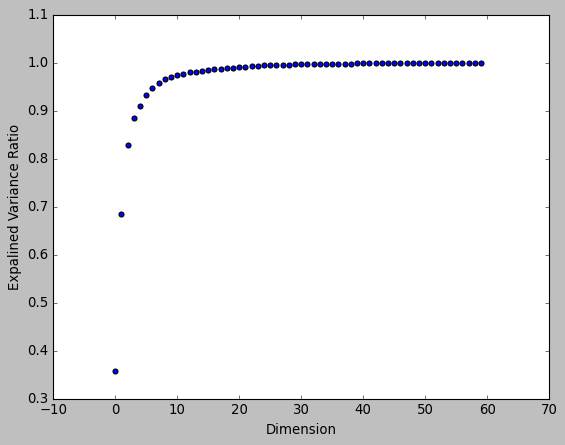

[[ 6.96910110e-01 -3.91367365e-15  3.78470803e-15]
 [-3.91367365e-15  6.33992086e-01 -7.09062472e-16]
 [ 3.78470803e-15 -7.09062472e-16  2.81113446e-01]]
Explained variance 3 PCs: 0.9059762399040041


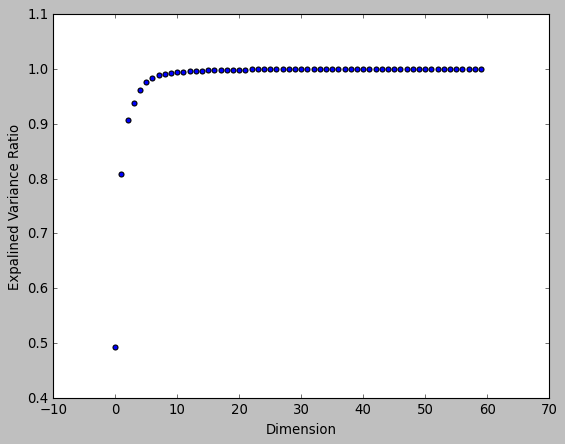

[[ 9.47861286e-01  1.14761328e-14 -6.09842493e-15]
 [ 1.14761328e-14  6.05043211e-01  1.30892629e-14]
 [-6.09842493e-15  1.30892629e-14  1.86266481e-01]]
Explained variance 3 PCs: 0.8520193938389856


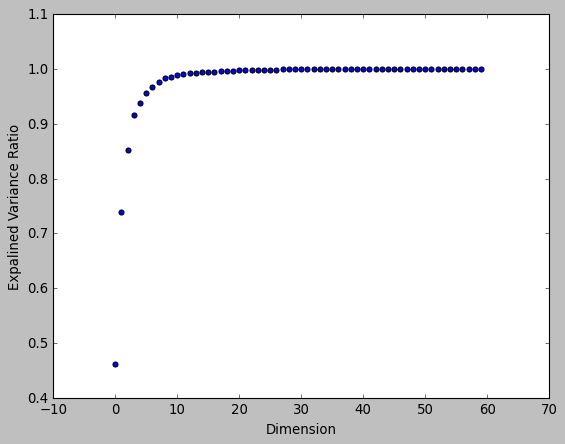

[[ 8.76826241e-01  1.43498597e-14 -3.11442522e-14]
 [ 1.43498597e-14  5.26198582e-01  1.59691229e-14]
 [-3.11442522e-14  1.59691229e-14  2.13422743e-01]]
Explained variance 3 PCs: 0.8793702815384603


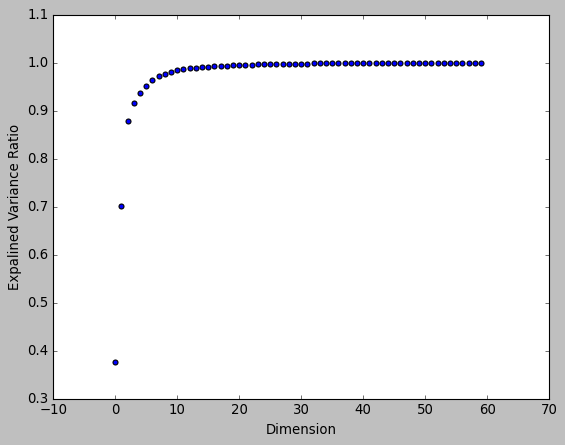

[[ 7.15532838e-01 -4.66423842e-14  6.39180832e-16]
 [-4.66423842e-14  6.18637691e-01  3.37478149e-15]
 [ 6.39180832e-16  3.37478149e-15  3.37875747e-01]]
Explained variance 3 PCs: 0.8831290033022858


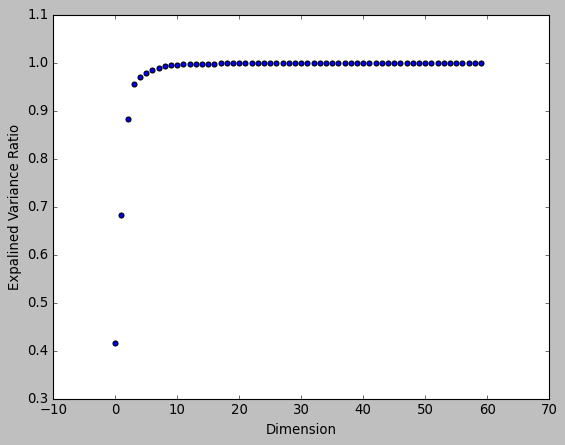

[[ 8.16124662e-01  9.26960187e-15 -4.19524585e-14]
 [ 9.26960187e-15  5.21817823e-01  3.89493415e-15]
 [-4.19524585e-14  3.89493415e-15  3.89247377e-01]]


In [9]:
for i, length in enumerate(lengths):
    # inspecting inter-dimensional variance with PCA
    if i == 0:
        idx = 0
    else:
        idx += lengths[i-1]

    traj = rats[idx:idx+length, :]

    pca = PCA()
    pca.fit(traj)
    
    # STORE EXPLAINED VARIANCE    
    explained_var.append(pca.explained_variance_ratio_)
    explained_var_plot = [np.sum(pca.explained_variance_ratio_[0:i+1]) for i in range(len(pca.explained_variance_ratio_))]

    plt.scatter(np.arange(traj.shape[1]), explained_var_plot)
    print('Explained variance 3 PCs:', sum(pca.explained_variance_ratio_[0:3]))
    plt.ylabel('Expalined Variance Ratio')
    plt.xlabel('Dimension')
    plt.show()

    # reduce data according to explained variance values using linear PCA
    pca = PCA(n_components=3)
    reduced_traj = pca.fit_transform(traj)
    reduced_traj.shape

    print(np.cov(np.transpose(reduced_traj)))

## Dimensionality Reduction - Visualization

<function matplotlib.pyplot.show(close=None, block=None)>

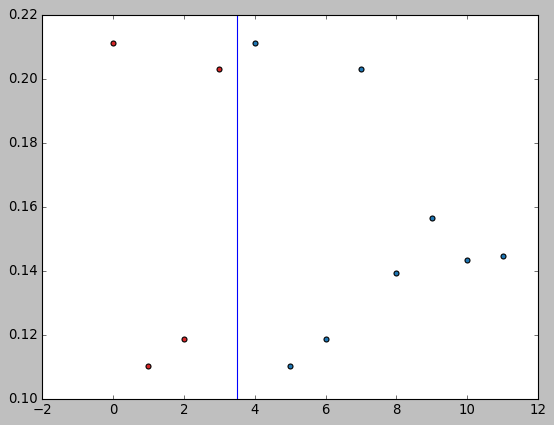

In [11]:
how_many = [4, 8]
PC1 = []
PC2 = []
PC3 = []
for i in range(len(explained_var)):
    PC1.append(explained_var[i][0])
    PC2.append(explained_var[i][1])
    PC3.append(explained_var[i][2])
    
plt.scatter(np.arange(how_many[0]), PC3[0:4], c='#d62728')
plt.scatter(np.arange(how_many[0], how_many[0] + how_many[1]), PC3[4:12], c='#1f77b4')
plt.axvline(x=3.5)
plt.show
